## CASE STUDY 3: INDEPENDENT ALONG-TRACK WITH HIGHER INSTRUMENTAL NOISE

__INTRODUCTION__

We here propose to show the behaviour of the spectral analysis in an OSSE case study based on NATL60 simulation.
The input comes from hourly SSH data from a 1 year long period of the run NATL60-CJM165 made at IGE (Grenoble).
We used the SWOTsimulator to sample alongtrack data (nadir-like dataset) on this simulation. The constellation is similar to the 20030101-20031231 period: Jason 1, Envisat, Geosat2, Topex/Poseidon interleaved. SWOTsimulator gives us the true SSH (SSH$_{model}$) and a pseudo-obs SSH (SSH$_{obs}$ = SSH$_{model}$ + white noise). These pseudo-obs SSH$_{obs}$ are then used in the DUACS mapping.

__CASE STUDY #3 SUMMARY:__
- the along-track of reference (i.e., for comparison) is __Geosat2__. In this case study #3, this along-track __is NOT included__ in the mapping. __We virtually add extra noise to this reference along-track to simulate a case where the along-track resolution is above the filtering properties of the DUACS system__
- the SSH$_{map}$ are generated from __3 nadir altimeters__ TPN, J1, EN with the DUACS system
- we focus on the region in the north-atlantic bassin (__10°x10° box centered near 330°E-44°N__)

PYTHON MODULE

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from matplotlib.ticker import FormatStrFormatter

__READ THE SSH SEGMENTS__

_Note_: The SSH segments were generated using same algorithm as for the study described in the manuscript. There are 800km long, referenced by their mean latitude and mean longitude and they overlap over 25%

__NOTATION__

- __SSH$_{model}$__: alongtrack SSH from model
- __SSH$_{obs}$__: alongtrack SSH from model including white noise
- __SSH$_{map}$__: SSH mapped with the DUACS algorithm using 3 altimeters data, and interpolated onto the alongtrack SSH$_{model}$ path
- __intrumental_error__: SSH$_{obs}$ minus SSH$_{model}$
- __mapping_error__: SSH$_{model}$ minus SSH$_{map}$

In [2]:
nc = Dataset('./data/dataset_independent_alongtrack_G2.nc','r')
ssh_model = nc.variables['ssh_model'][:]
ssh_obs = nc.variables['ssh_obs'][:]
ssh_map = nc.variables['ssh_map'][:]
dx = nc.variables['resolution'][:]
nperseg = nc.dimensions['segment_size'].size
nc.close()

__COMPUTE INSTRUMENTAL ERROR & MAPPING ERROR__

In [3]:
# Extra noise
extra_noise = np.random.normal(0,0.16, ssh_model.size)
intrumental_error = ssh_obs - ssh_model + extra_noise
mapping_error = ssh_model - ssh_map
ssh_obs = intrumental_error + ssh_model

__QUANTITY THAT CAN BE EVALUATED FROM ALTIMETRY DATA__ : SSH$_{map}$ - SSH$_{obs}$

In [4]:
# What can evaluated from altimetry product (we don't have access to ssh_model)
ssh_obs_minus_map = ssh_obs - ssh_map

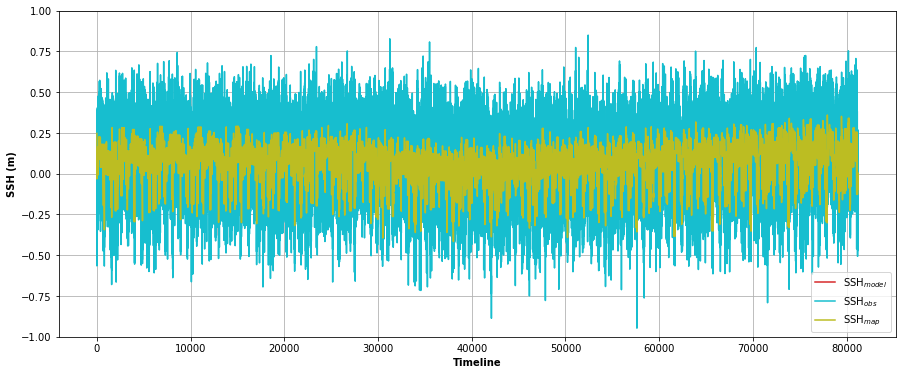

In [5]:
plt.figure(figsize=(15, 6))
plt.xlabel("Timeline", fontweight='bold')
plt.ylabel("SSH (m)", fontweight='bold')
plt.plot(ssh_model, c='C3', label='SSH$_{model}$')
plt.plot(ssh_obs, c='C9', label='SSH$_{obs}$')
plt.plot(ssh_map, c='C8', label='SSH$_{map}$')
plt.ylim(-1, 1)
plt.legend(loc='best')
plt.grid()

__SPECTRAL CONTENT OF EACH SIGNAL__

In [6]:
freq, psd_ssh_model = signal.welch(ssh_model, 
                                   fs=1/dx, 
                                   nperseg=nperseg, 
                                   scaling='density', 
                                   noverlap=0)

_, psd_ssh_obs = signal.welch(ssh_obs, 
                              fs=1/dx, 
                              nperseg=nperseg, 
                              scaling='density', 
                              noverlap=0)

_, psd_ssh_map = signal.welch(ssh_map, 
                              fs=1/dx, 
                              nperseg=nperseg, 
                              scaling='density', 
                              noverlap=0)

_, psd_intrumental_error = signal.welch(intrumental_error, 
                                        fs=1/dx, 
                                        nperseg=nperseg, 
                                        scaling='density', 
                                        noverlap=0)

_, psd_mapping_error = signal.welch(mapping_error, 
                                    fs=1/dx, 
                                    nperseg=nperseg, 
                                    scaling='density', 
                                    noverlap=0)

_, psd_ssh_obs_minus_map = signal.welch(ssh_obs_minus_map, 
                                         fs=1/dx, 
                                         nperseg=nperseg, 
                                         scaling='density', 
                                         noverlap=0)

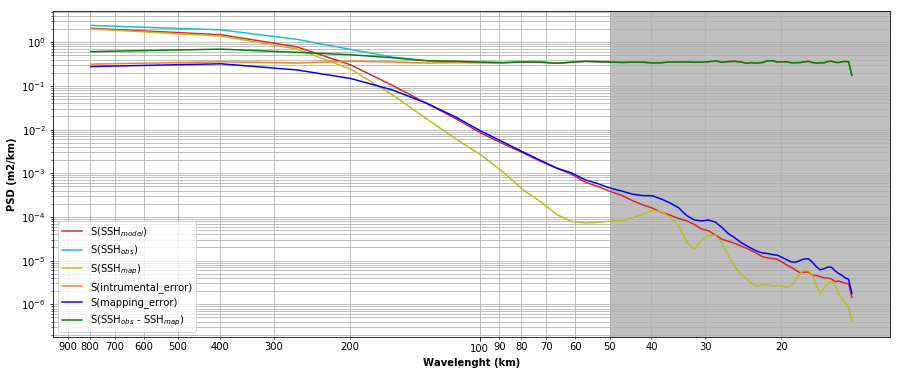

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(1/freq, psd_ssh_model, c='C3', label='S(SSH$_{model}$)')
plt.plot(1/freq, psd_ssh_obs, c='C9', label='S(SSH$_{obs}$)')
plt.plot(1/freq, psd_ssh_map, c='C8', label='S(SSH$_{map}$)')
plt.plot(1./freq, psd_intrumental_error, c='C1', label='S(intrumental_error)')
plt.plot(1./freq, psd_mapping_error, c='b', label='S(mapping_error)')
plt.plot(1./freq, psd_ssh_obs_minus_map, c='g', label='S(SSH$_{obs}$ - SSH$_{map}$)')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Wavelenght (km)', fontweight='bold')
plt.ylabel('PSD (m2/km)', fontweight='bold')
plt.legend(loc='best')
plt.grid(which='both')
ax.axvspan(0, 50, color='grey', alpha=0.5)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.xaxis.set_minor_formatter(FormatStrFormatter('%.f'))
plt.show()

The figure represents the power spectral densities from each type of signal. 
The agreement of the power spectral density S(SSH$_{obs}$), S(SSH$_{map}$) and S(SSH$_{model}$) is less obvious than in the previous case study.

The signal-noise-ratio for the input along-track is between 200-300km (crossing of the red and orange lines), setting the along-track resolution limit as defined in Dufau et al (2016).

For all wavelenght the power spectral density of the instrumental error S(instrumental_error) is larger than the power spectral density of the mapping error S(mapping_error) .

The wavelenght in the grey area are below the grid spacing of the DUACS maps. The power spectral density S(SSH$_{map}$) below this limit is hence resulting from the interpolation of the SSH$_{map}$ onto the alongtrack position

__CROSS SPECTRUM__

In [8]:
freq, cross_psd_ssh_map_ssh_obs = signal.csd(ssh_map, 
                                             ssh_obs, 
                                             fs=1./dx, 
                                             nperseg=nperseg, 
                                             noverlap=0)

__SPECTRAL COHERENCE__

In [9]:
# Compute coherence ssh_map ssh_obs
freq, coh_ssh_map_ssh_obs = signal.coherence(ssh_map, 
                                             ssh_obs, 
                                             fs=1/dx, 
                                             nperseg=nperseg, 
                                             noverlap=0)

# Compute coherence ssh_map ssh_model
_, coh_ssh_map_ssh_model = signal.coherence(ssh_map, 
                                            ssh_model, 
                                            fs=1/dx, 
                                            nperseg=nperseg, 
                                            noverlap=0)

/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


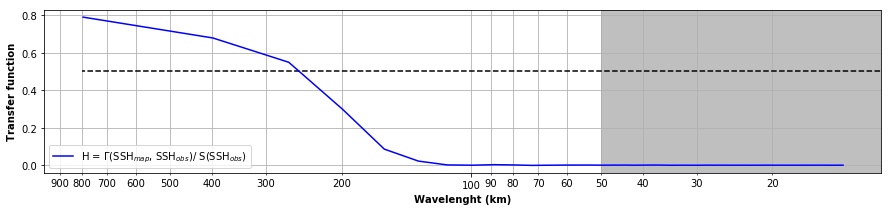

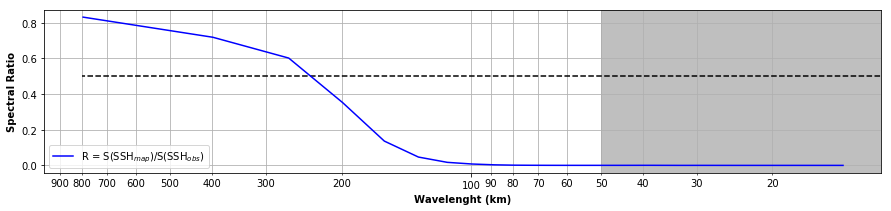

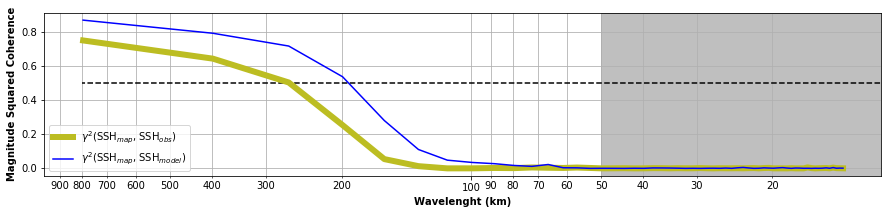

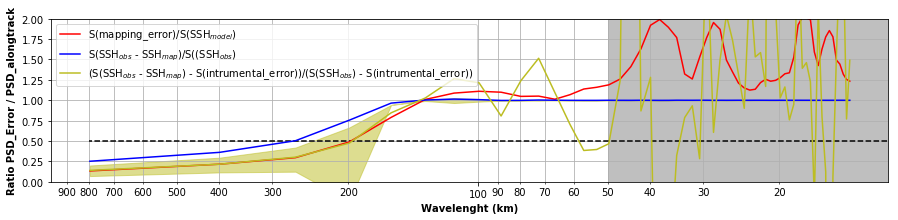

In [10]:
# TRANSFER FUNCTION
fig, ax = plt.subplots(figsize=(15, 3))
plt.plot(1./freq, cross_psd_ssh_map_ssh_obs/psd_ssh_obs, 
         c='b', label='H = $\Gamma$(SSH$_{map}$, SSH$_{obs}$)/ S(SSH$_{obs}$)')
plt.xscale('log')
plt.gca().invert_xaxis()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.xaxis.set_minor_formatter(FormatStrFormatter('%.f'))
plt.xlabel('Wavelenght (km)', fontweight='bold')
plt.ylabel('Transfer function', fontweight='bold')
plt.hlines(0.5, xmin=0, xmax=800, linestyle='--')
plt.legend()
ax.axvspan(0, 50, color='grey', alpha=0.5)
plt.grid(which='both')

# SPECTRAL RATIO
fig, ax = plt.subplots(figsize=(15, 3))
plt.plot(1./freq, psd_ssh_map/psd_ssh_obs, c='b', 
         label='R = S(SSH$_{map}$)/S(SSH$_{obs}$)')
plt.xscale('log')
plt.gca().invert_xaxis()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.xaxis.set_minor_formatter(FormatStrFormatter('%.f'))
plt.xlabel('Wavelenght (km)', fontweight='bold')
plt.ylabel('Spectral Ratio', fontweight='bold')
plt.hlines(0.5, xmin=0, xmax=800, linestyle='--')
plt.legend()
ax.axvspan(0, 50, color='grey', alpha=0.5)
plt.grid(which='both')

# MAGNITUDE SQUARED COHERENCE
fig, ax = plt.subplots(figsize=(15, 3))
plt.plot(1./freq, coh_ssh_map_ssh_obs, c='C8', 
         label='$\gamma^2$(SSH$_{map}$, SSH$_{obs}$)', lw=6)
plt.plot(1./freq, coh_ssh_map_ssh_model, c='b', 
         label='$\gamma^2$(SSH$_{map}$, SSH$_{model}$)')
plt.hlines(0.5, xmin=0, xmax=800, linestyle='--')
plt.gca().invert_xaxis()
plt.grid(which='both')
plt.legend()
plt.xscale('log')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.xaxis.set_minor_formatter(FormatStrFormatter('%.f'))
ax.axvspan(0, 50, color='grey', alpha=0.5)
plt.xlabel('Wavelenght (km)', fontweight='bold')
plt.ylabel('Magnitude Squared Coherence', fontweight='bold')

# RATIO ERROR SPECTRUM / (SSH_OBS SPECTRUM)
fig, ax = plt.subplots(figsize=(15, 3))
plt.hlines(0.5, xmin=0, xmax=800, linestyle='--')
plt.plot(1./freq, (psd_mapping_error)/psd_ssh_model, c='r', 
        label='S(mapping_error)/S(SSH$_{model}$)')
plt.plot(1./freq, (psd_ssh_obs_minus_map)/(psd_ssh_obs), c='b', 
         label='S(SSH$_{obs}$ - SSH$_{map}$)/S((SSH$_{obs}$)')
plt.plot(1./freq, (psd_ssh_obs_minus_map - psd_intrumental_error)/
         (psd_ssh_obs - psd_intrumental_error), c='C8', 
         label='(S(SSH$_{obs}$ - SSH$_{map}$) - S(intrumental_error))/(S(SSH$_{obs}$) - S(intrumental_error))')

percent = 0.5

upper_bound = np.maximum((psd_ssh_obs_minus_map - 
                          (1 - percent)*psd_intrumental_error)/
                (psd_ssh_obs - (1 - percent)*psd_intrumental_error), 
                         np.abs(psd_ssh_obs_minus_map - 
                          (1 + percent)*psd_intrumental_error)/
                (psd_ssh_obs - (1 + percent)*psd_intrumental_error))

lower_bound = np.minimum((psd_ssh_obs_minus_map - 
                          (1 - percent)*psd_intrumental_error)/
                (psd_ssh_obs - (1 - percent)*psd_intrumental_error), 
                         (psd_ssh_obs_minus_map - 
                          np.abs(1 + percent)*psd_intrumental_error)/
                (psd_ssh_obs - (1 + percent)*psd_intrumental_error))

ax.fill_between(1./freq, lower_bound, upper_bound, color='C8', alpha=0.5)
plt.ylim(0,2)
plt.gca().invert_xaxis()
plt.grid(which='both')
plt.legend()
plt.xscale('log')
ax.axvspan(0, 50, color='grey', alpha=0.5)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.xaxis.set_minor_formatter(FormatStrFormatter('%.f'))
plt.xlabel('Wavelenght (km)', fontweight='bold')
plt.ylabel('Ratio PSD_Error / PSD_alongtrack', fontweight='bold')

plt.show()



__CONCLUSIONS__

Here the spectral ratio corrected from S(intrumental error isrelatively similar to PSD(mapping_error)/PSD(SSH$_{model}$)) but it becomes very sensitive to the amount of instrumental noise (yellow spread delimiting a $\pm$ 50% increase/decrese noise level)